<a href="https://colab.research.google.com/github/kishore145/AI-ML-Foundations/blob/master/Neural%20Networks/11_NLP_LSTM_based_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dependencies and Set Hyperparameters


In [0]:
# Import dependencies
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, SpatialDropout1D
from tensorflow.keras.layers import LSTM # used for creating LSTM layer
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [0]:
# Set hyperparameters
# output directory name:
output_dir = 'model_output/lstm'

# training:
epochs = 4 
batch_size = 128

# vector-space embedding: 
n_dim = 64 
n_unique_words = 10000 
max_review_length = 100 # lstm usually remembers 100 time steps.
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# RNN layer architecture:
n_lstm = 256 
drop_lstm = 0.2

# Load and Pre-Process Data

In [3]:
# Load data
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
# Preprocess data
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

# Neural Network Section

In [0]:
# Design Neural Network
# Create model
model = Sequential()

# Add first hidden layer - embedding
model.add(Embedding(input_dim=n_unique_words, 
                    output_dim= n_dim,
                    input_length= max_review_length))
model.add(SpatialDropout1D(drop_embed))

# Add second hiddden layer - LSTM
model.add(LSTM(units = n_lstm, dropout = drop_lstm))

# Add o/p layer
model.add(Dense(1, activation = 'sigmoid'))

In [7]:
# Review model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 64)           640000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               328704    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 968,961
Trainable params: 968,961
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Configure model
model.compile(optimizer='nadam', loss = 'binary_crossentropy', metrics=['accuracy'])

In [0]:
# Create model checkpoints
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [10]:
# Train model
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid, y_valid), callbacks=[modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 6s 31ms/step - loss: 0.5848 - accuracy: 0.6958 - val_loss: 0.4324 - val_accuracy: 0.8153
Epoch 2/4
196/196 [==============================] - 6s 29ms/step - loss: 0.3376 - accuracy: 0.8590 - val_loss: 0.3555 - val_accuracy: 0.8445
Epoch 3/4
196/196 [==============================] - 6s 29ms/step - loss: 0.2772 - accuracy: 0.8890 - val_loss: 0.3566 - val_accuracy: 0.8521
Epoch 4/4
196/196 [==============================] - 6s 29ms/step - loss: 0.2351 - accuracy: 0.9074 - val_loss: 0.3755 - val_accuracy: 0.8463


# Evaluate

In [0]:
# Load model with highest accuracy
model.load_weights(output_dir+"/weights.03.hdf5")

In [0]:
# Make predictions using best model
y_hat = model.predict(x_valid)

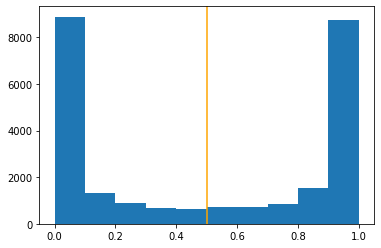

In [13]:
# Plot predictions
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [14]:
# Find AUC-ROC value
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
print("AUC-ROC Value: {:0.2f}".format(pct_auc))

AUC-ROC Value: 93.11


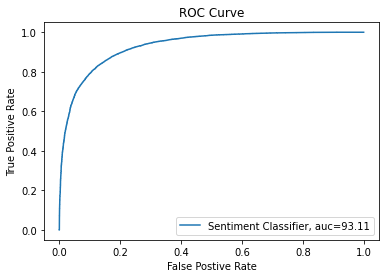

In [15]:
fpr, tpr, auc = roc_curve(y_valid,  y_hat)
plt.plot(fpr,tpr,label="Sentiment Classifier, auc="+"{:0.2f}".format(pct_auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [0]:
# As is evident, LSTM performs much better on sentiment classification 
# than vanilla RNN networks due to it's ability to remember words that occur
# earlier in the review.  